# Component 2 Travel-Time Fit Validation

This notebook mirrors the wait-time diagnostics but focuses on Component 2 travel-time modeling. It uses the exact binning, rush/weekend slicing, and Gamma/lognormal fitting code from `scripts/component2_build_travel_stats.py` to explain why those modeling choices are reasonable.

* Load January 2024 Yellow Taxi and Citi Bike trips.
* Bucket trips into 2 km distance ranges and rush/weekend cohorts.
* Fit Gamma distributions whenever we have at least 50 samples and compare them to the empirical histograms.
* Compare Gamma cohort fits against a continuous lognormal GLM and inspect diagnostics for both approaches.

In [72]:
# Component 2 travel-time diagnostic utilities
# %pip install --quiet pandas numpy plotly ipywidgets

import importlib.util
from pathlib import Path
import sys
import math

import numpy as np
import pandas as pd
import plotly.graph_objects as go
import plotly.io as pio
import plotly.express as px
import ipywidgets as widgets
import statsmodels.api as sm
from scipy.special import gammaln
from scipy.stats import lognorm
from IPython.display import display, Markdown, Image

In [73]:
# =============================================================================
# Configuration and shared helpers
# =============================================================================


PROJECT_ROOT = Path("/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit")

if not (PROJECT_ROOT / 'src').exists():
    for candidate in PROJECT_ROOT.parents:
        if (candidate / 'src').exists():
            PROJECT_ROOT = candidate
            break

DATA_ROOT = PROJECT_ROOT / 'data' / 'raw'
TAXI_PATH = DATA_ROOT / 'yellow_tripdata_2024-01.parquet'
BIKE_ROOT = DATA_ROOT / 'citibike'
BIKE_GLOB = '202401-citibike-tripdata_*.csv'
TAXI_MAX_ROWS = 4_000_000
BIKE_MAX_ROWS = 2_000_000

spec = importlib.util.spec_from_file_location(
    'component2_build_travel_stats', PROJECT_ROOT / 'scripts' / 'component2_build_travel_stats.py'
)
travel_stats = importlib.util.module_from_spec(spec)
spec.loader.exec_module(travel_stats)

BIN_WIDTH_KM=travel_stats.BIN_WIDTH_KM
MAX_DISTANCE_KM = travel_stats.MAX_DISTANCE_KM
GAMMA_MIN_SAMPLES = travel_stats.GAMMA_MIN_SAMPLES
REGRESSION_MIN_SAMPLES = travel_stats.REGRESSION_MIN_SAMPLES

print(f"Project root detected at: {PROJECT_ROOT}")

Project root detected at: /Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit


## Load and preprocess taxi + Citi Bike samples

We reuse the helper functions from `component2_build_travel_stats.py` so the notebook adheres to the exact same filters (distance limits, rush/weekend flags, distance bins, etc.).

In [74]:
def load_data():
    print('Loading taxi trips ...')
    taxi = travel_stats.load_taxi_trips(TAXI_PATH, TAXI_MAX_ROWS)
    print(f'Taxi rows after filtering: {len(taxi):,}')
    print('Loading Citi Bike trips ...')
    bike = travel_stats.load_bike_trips(BIKE_ROOT, BIKE_GLOB, BIKE_MAX_ROWS)
    print(f'Bike rows after filtering: {len(bike):,}')
    combined = pd.concat([taxi, bike], ignore_index=True)
    print(f'Combined rows: {len(combined):,}')
    return taxi, bike, combined


taxi_trips, bike_trips, combined_trips = load_data()
for frame in (taxi_trips, bike_trips, combined_trips):
    frame['distance_bin_label'] = frame['distance_bin'].astype(str)
    frame.loc[frame['distance_bin'].isna(), 'distance_bin_label'] = np.nan

combined_trips.head()

Loading taxi trips ...
Taxi rows after filtering: 2,559,175
Loading Citi Bike trips ...
Bike rows after filtering: 1,841,613
Combined rows: 4,400,788


,tpep_pickup_datetime,tpep_dropoff_datetime,trip_distance,pickup_dt,dropoff_dt,travel_min,distance_km,event_time,hour,is_weekend,...,mode,started_at,ended_at,start_lat,start_lng,end_lat,end_lng,start_dt,end_dt,distance_bin_label
0,2024-01-01 00:57:55,2024-01-01 01:17:43,1.72,2024-01-01 00:57:55,2024-01-01 01:17:43,19.800000,2.768065,2024-01-01 00:57:55,0,False,...,taxi,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2-4km
1,2024-01-01 00:03:00,2024-01-01 00:09:36,1.80,2024-01-01 00:03:00,2024-01-01 00:09:36,6.600000,2.896812,2024-01-01 00:03:00,0,False,...,taxi,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2-4km
2,2024-01-01 00:17:06,2024-01-01 00:35:01,4.70,2024-01-01 00:17:06,2024-01-01 00:35:01,17.916667,7.563898,2024-01-01 00:17:06,0,False,...,taxi,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,6-8km
3,2024-01-01 00:36:38,2024-01-01 00:44:56,1.40,2024-01-01 00:36:38,2024-01-01 00:44:56,8.300000,2.253076,2024-01-01 00:36:38,0,False,...,taxi,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,2-4km
4,2024-01-01 00:46:51,2024-01-01 00:52:57,0.80,2024-01-01 00:46:51,2024-01-01 00:52:57,6.100000,1.287472,2024-01-01 00:46:51,0,False,...,taxi,NaN,NaN,NaN,NaN,NaN,NaN,NaT,NaT,0-2km


## Bin-level summaries (Gamma baseline)

The binning logic groups trips by mode, 2 km distance bucket, rush vs off-peak, and weekday vs weekend. We only trust Gamma parameters with at least 50 samples; the lognormal GLM provides the smooth fallback instead of a linear regression.

In [75]:
def parse_distance_start(label: str) -> float:
    try:
        return float(label.replace('km', '').split('-')[0])
    except Exception:
        return math.inf


bin_stats = travel_stats.summarize_bins(combined_trips)
bin_stats['distance_bin'] = bin_stats['distance_bin'].astype(str)
bin_stats['meets_gamma'] = bin_stats['sample_count'] >= GAMMA_MIN_SAMPLES
bin_stats['distance_start'] = bin_stats['distance_bin'].apply(parse_distance_start)

bin_stats_summary = (
    bin_stats.groupby(['mode', 'distance_bin', 'distance_start'])
    .agg(
        cohorts=('sample_count', 'size'),
        min_samples=('sample_count', 'min'),
        median_samples=('sample_count', 'median'),
        max_samples=('sample_count', 'max'),
    )
    .reset_index()
    .sort_values(['mode', 'distance_start'])
)
bin_stats_summary = bin_stats_summary.drop(columns='distance_start')

distance_levels = sorted(
    [label for label in bin_stats['distance_bin'].unique() if isinstance(label, str) and label != 'nan'],
    key=parse_distance_start,
)

print(f'Bin stats rows: {len(bin_stats):,}')
display(bin_stats_summary.head(12))

low_sample_bins = (
    bin_stats.sort_values('sample_count')[
        ['mode', 'distance_bin', 'is_rush', 'is_weekend', 'sample_count', 'meets_gamma']
    ].head(10)
)
print('Busiest low-sample cohorts (help explain the 50-sample rule):')
display(low_sample_bins)

mode_counts = {}
for mode in sorted(combined_trips['mode'].unique()):
    mode_counts[mode] = len(combined_trips[combined_trips['mode'] == mode])

print('Samples per mode:', mode_counts)

gamma_coverage = (
    bin_stats.groupby('mode')['meets_gamma'].mean().rename('fraction_gamma_ready').to_frame()
)
print('Share of cohorts meeting Gamma threshold:')
display(gamma_coverage)


/Users/atharvramesh/UCSD/Fall2025/ECE225A/NYC_Public_Transit/scripts/component2_build_travel_stats.py:176: FutureWarning:

The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.



Bin stats rows: 48


,mode,distance_bin,cohorts,min_samples,median_samples,max_samples
0,bike,0-2km,4,74675,320473.5,558079
2,bike,2-4km,4,23493,109278.0,173072
3,bike,4-6km,4,5843,28848.0,43211
4,bike,6-8km,4,1792,8745.0,13602
5,bike,8-10km,4,504,2798.0,4244
1,bike,10-12km,4,116,733.0,1231
6,taxi,0-2km,4,65709,221712.5,472922
8,taxi,2-4km,4,61308,214003.5,456260
9,taxi,4-6km,4,22948,78479.0,174186
10,taxi,6-8km,4,9282,31787.5,71923


Busiest low-sample cohorts (help explain the 50-sample rule):


,mode,distance_bin,is_rush,is_weekend,sample_count,meets_gamma
23,bike,10-12km,True,True,116,True
21,bike,10-12km,False,True,396,True
19,bike,8-10km,True,True,504,True
22,bike,10-12km,True,False,1070,True
20,bike,10-12km,False,False,1231,True
17,bike,8-10km,False,True,1426,True
15,bike,6-8km,True,True,1792,True
47,taxi,10-12km,True,True,2810,True
18,bike,8-10km,True,False,4170,True
16,bike,8-10km,False,False,4244,True


Samples per mode: {'bike': 1841613, 'taxi': 2559175}
Share of cohorts meeting Gamma threshold:


,fraction_gamma_ready
mode,
bike,1.0
taxi,1.0


## Sample count coverage per cohort

The table below shows how many observations we have for each (mode, distance bin, rush/off-peak, weekday/weekend) combination and whether it meets the 50-sample minimum.

In [76]:
sample_counts = bin_stats.copy()
sample_counts['rush_label'] = np.where(sample_counts['is_rush'], 'Rush', 'Off-peak')
sample_counts['weekend_label'] = np.where(sample_counts['is_weekend'], 'Weekend', 'Weekday')
summary_view = sample_counts[
    ['mode', 'distance_bin', 'distance_start', 'rush_label', 'weekend_label', 'sample_count', 'meets_gamma']
].sort_values(['mode', 'distance_start', 'rush_label', 'weekend_label'])
summary_view = summary_view.drop(columns='distance_start')
summary_view.head(20)


,mode,distance_bin,rush_label,weekend_label,sample_count,meets_gamma
0,bike,0-2km,Off-peak,Weekday,558079,True
1,bike,0-2km,Off-peak,Weekend,178544,True
2,bike,0-2km,Rush,Weekday,462403,True
3,bike,0-2km,Rush,Weekend,74675,True
4,bike,2-4km,Off-peak,Weekday,173072,True
5,bike,2-4km,Off-peak,Weekend,58341,True
6,bike,2-4km,Rush,Weekday,160215,True
7,bike,2-4km,Rush,Weekend,23493,True
8,bike,4-6km,Off-peak,Weekday,43211,True
9,bike,4-6km,Off-peak,Weekend,15190,True


## Interactive Gamma fit diagnostics

Use the controls to select a transportation mode, distance bucket, and rush/weekend cohort. The histogram shows the empirical travel-time distribution for that slice, and the red curve overlays the fitted Gamma probability density scaled by sample count. This mirrors the logic in the data pipeline and demonstrates why the Gamma assumption is reasonable when the `≥ 50` rule is satisfied.

In [77]:
def gamma_pdf(x, k, theta):
    if not (np.isfinite(k) and np.isfinite(theta) and k > 0 and theta > 0):
        return np.full_like(x, np.nan)
    return (x ** (k - 1) * np.exp(-x / theta)) / (math.gamma(k) * (theta ** k))


def render_travel_bin(mode, distance_bin_label, is_rush, is_weekend):
    subset = combined_trips[(combined_trips['mode'] == mode) &
                            (combined_trips['distance_bin_label'] == distance_bin_label) &
                            (combined_trips['is_rush'] == is_rush) &
                            (combined_trips['is_weekend'] == is_weekend)]
    row = bin_stats[(bin_stats['mode'] == mode) &
                    (bin_stats['distance_bin'] == distance_bin_label) &
                    (bin_stats['is_rush'] == is_rush) &
                    (bin_stats['is_weekend'] == is_weekend)]
    if row.empty or subset.empty:
        fig = go.Figure()
        fig.add_annotation(text='No samples for this combination',
                           xref='paper', yref='paper', x=0.5, y=0.5, showarrow=False)
        fig.update_layout(height=400)
        return fig, {}

    row = row.iloc[0]
    bin_width = 1.0
    max_minutes = max(15, subset['travel_min'].max())
    bins = np.arange(0, max_minutes + bin_width, bin_width)
    counts, edges = np.histogram(subset['travel_min'], bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])

    fig = go.Figure()
    fig.add_bar(x=centers, y=counts, name='Empirical histogram', marker_color='#1f77b4', opacity=0.75)

    k_val, theta_val = row['gamma_k'], row['gamma_theta']
    if np.isfinite(k_val) and np.isfinite(theta_val) and row['sample_count'] >= GAMMA_MIN_SAMPLES:
        x_grid = np.linspace(0, max_minutes, 250)
        pdf_scaled = gamma_pdf(x_grid, k_val, theta_val) * row['sample_count'] * bin_width
        fig.add_trace(go.Scatter(x=x_grid, y=pdf_scaled, name=f"Gamma fit (k={k_val:.2f}, θ={theta_val:.2f})",
                                 line=dict(color='#d62728', width=3)))
    else:
        fig.add_annotation(text='Gamma parameters suppressed (<50 samples)',
                           xref='paper', yref='paper', x=0.5, y=0.9, showarrow=False, font=dict(color='#d62728'))

    fig.update_layout(
        title=f"{mode.title()} | {distance_bin_label} | {'Rush' if is_rush else 'Off-peak'} | {'Weekend' if is_weekend else 'Weekday'}",
        xaxis_title='Travel minutes',
        yaxis_title='Trip count',
        bargap=0.02,
        height=500,
    )

    metrics = {
        'sample_count': int(row['sample_count']),
        'mean_minutes (bin)': float(row['mean_min']),
        'var_minutes (bin)': float(row['var_min']),
        'gamma_k': float(k_val) if np.isfinite(k_val) else np.nan,
        'gamma_theta': float(theta_val) if np.isfinite(theta_val) else np.nan,
        'overall_mean': float(subset['travel_min'].mean()),
        'overall_var': float(subset['travel_min'].var(ddof=0)),
    }
    return fig, metrics


mode_widget = widgets.ToggleButtons(options=['taxi', 'bike'], description='Mode', layout=widgets.Layout(width='auto'))
distance_widget = widgets.Dropdown(options=distance_levels, description='Distance bin')
rush_widget = widgets.ToggleButtons(options=[('Off-peak', False), ('Rush', True)], description='Rush?')
weekend_widget = widgets.ToggleButtons(options=[('Weekday', False), ('Weekend', True)], description='Weekend?')

plot_output = widgets.Output()


def update_plot(*_):
    with plot_output:
        plot_output.clear_output(wait=True)
        fig, metrics = render_travel_bin(
            mode_widget.value, distance_widget.value, rush_widget.value, weekend_widget.value
        )
        display(fig)
        if metrics:
            metrics_df = pd.DataFrame(metrics, index=['value']).T
            display(metrics_df)

for w in [mode_widget, distance_widget, rush_widget, weekend_widget]:
    w.observe(update_plot, names='value')

controls = widgets.HBox([mode_widget, distance_widget, rush_widget, weekend_widget])
display(controls)
display(plot_output)

update_plot()

Output()

### Static Gamma example

The figure below is exported inside the notebook so viewers can see a representative Gamma overlay without executing widgets. Adjust the helper call if you prefer a different cohort.

**Gamma overlay snapshot — Bike, 2-4km, Off-peak, Weekday**

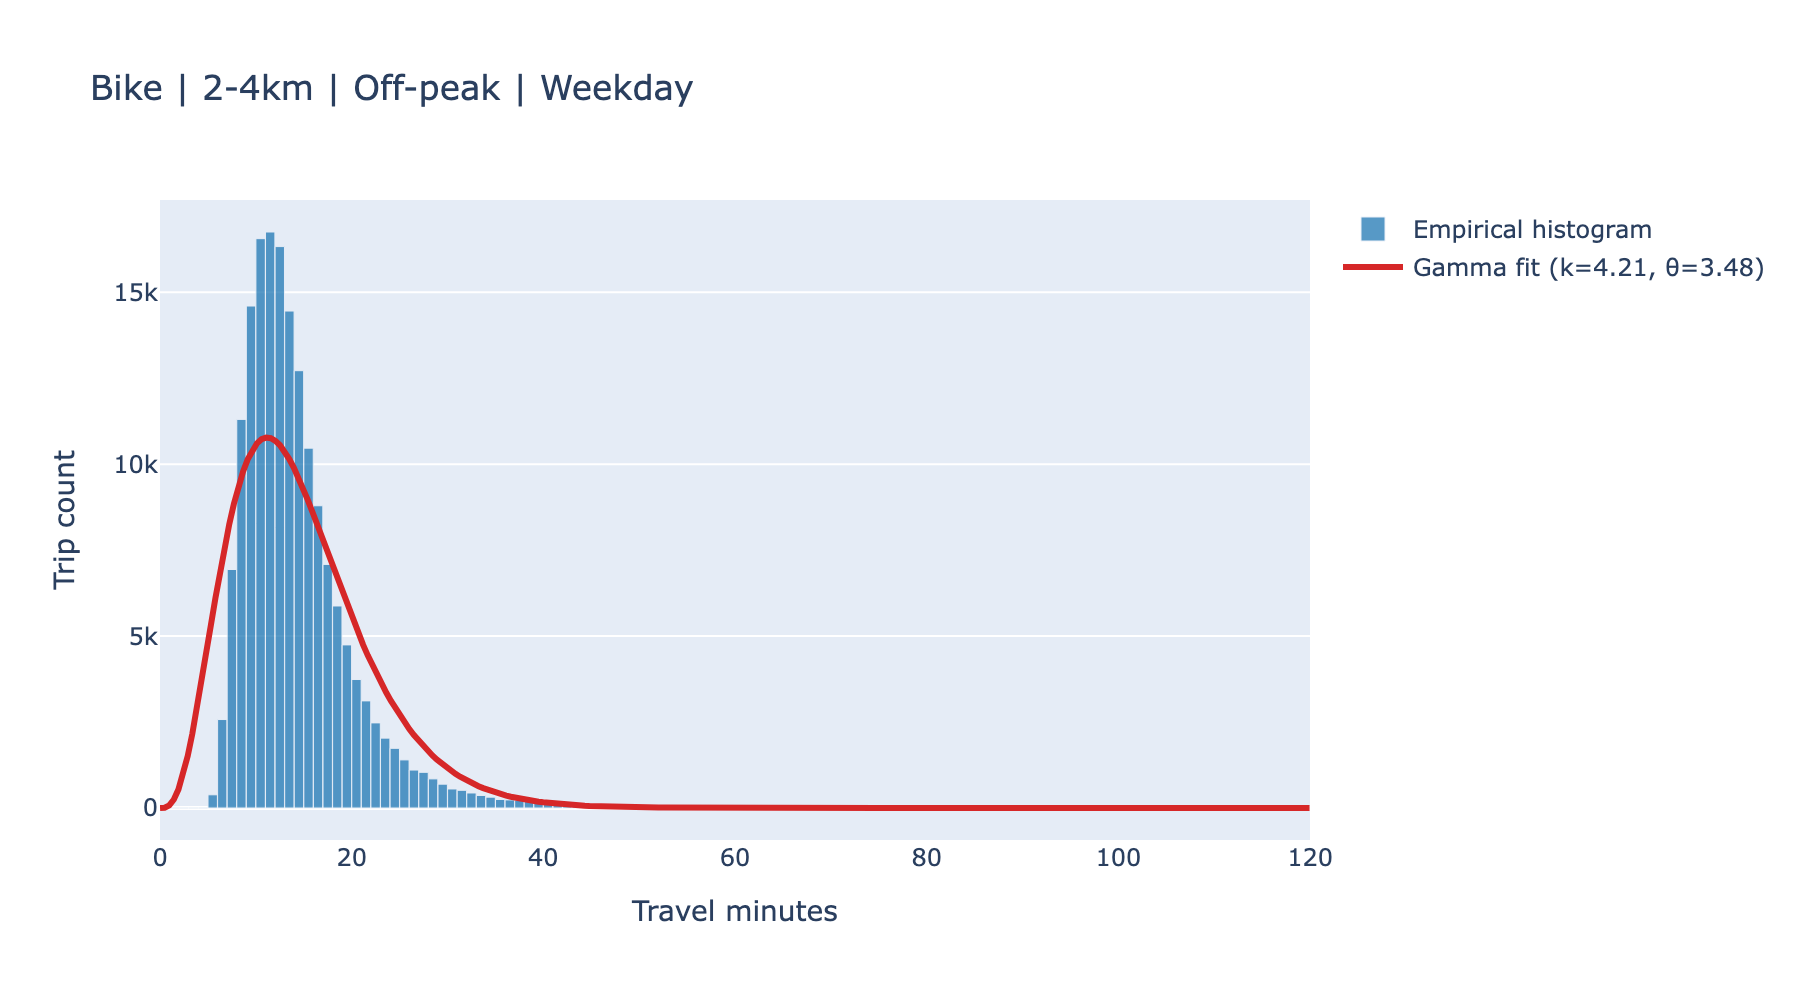

sample_count          173072.000000
mean_minutes (bin)        14.672698
var_minutes (bin)         51.124919
gamma_k                    4.211020
gamma_theta                3.484357
overall_mean              14.672698
overall_var               51.124919
Name: metrics, dtype: float64

In [78]:

def render_static_gamma_snapshot(
    mode='bike',
    distance_bin_label=None,
    is_rush=False,
    is_weekend=False,
):
    if distance_bin_label is None:
        distance_bin_label = distance_levels[1] if len(distance_levels) > 1 else distance_levels[0]
    fig, metrics = render_travel_bin(mode, distance_bin_label, is_rush, is_weekend)
    png = fig.to_image(format='png', width=900, height=500, scale=2)
    display(Markdown(f"**Gamma overlay snapshot — {mode.title()}, {distance_bin_label}, "
                     f"{'Rush' if is_rush else 'Off-peak'}, {'Weekend' if is_weekend else 'Weekday'}**"))
    display(Image(png))
    if metrics:
        display(pd.Series(metrics, name='metrics'))

render_static_gamma_snapshot()


## Cohort-level lognormal overlay

For the same mode/distance/rush/weekend slices we can overlay a lognormal PDF (fit via `log` moments) on top of the empirical histogram to show how well the distribution captures the right tail. Save the rendered figure for the report to justify preferring lognormal.

In [79]:

lognorm_plot_output = widgets.Output()
lognorm_mode_widget = widgets.ToggleButtons(options=['taxi', 'bike'], description='Mode')
lognorm_distance_widget = widgets.Dropdown(options=distance_levels, description='Distance bin')
lognorm_rush_widget = widgets.ToggleButtons(options=[('Off-peak', False), ('Rush', True)], description='Rush?')
lognorm_weekend_widget = widgets.ToggleButtons(options=[('Weekday', False), ('Weekend', True)], description='Weekend?')


def render_lognormal_overlay(mode, distance_bin_label, is_rush, is_weekend):
    subset = combined_trips[(combined_trips['mode'] == mode)
                            & (combined_trips['distance_bin_label'] == distance_bin_label)
                            & (combined_trips['is_rush'] == is_rush)
                            & (combined_trips['is_weekend'] == is_weekend)].copy()
    if subset.empty:
        fig = go.Figure()
        fig.add_annotation(text='No samples for this combination', x=0.5, y=0.5,
                           xref='paper', yref='paper', showarrow=False)
        fig.update_layout(height=400)
        return fig, None
    log_vals = np.log(subset['travel_min'])
    mu = log_vals.mean()
    sigma = log_vals.std(ddof=0)
    bin_width = 1.0
    max_minutes = max(15, subset['travel_min'].max())
    bins = np.arange(0, max_minutes + bin_width, bin_width)
    counts, edges = np.histogram(subset['travel_min'], bins=bins)
    centers = 0.5 * (edges[:-1] + edges[1:])

    fig = go.Figure()
    fig.add_bar(x=centers, y=counts, name='Empirical histogram', marker_color='#4c78a8', opacity=0.75)
    x_grid = np.linspace(0.01, max_minutes, 400)
    pdf_scaled = lognorm.pdf(x_grid, s=sigma, scale=np.exp(mu)) * len(subset) * bin_width
    fig.add_trace(
        go.Scatter(
            x=x_grid,
            y=pdf_scaled,
            name=f'Lognormal fit (μ={mu:.2f}, σ={sigma:.2f})',
            line=dict(color='#d62728', width=3),
        )
    )
    fig.update_layout(
        title=f"{mode.title()} | {distance_bin_label} | {'Rush' if is_rush else 'Off-peak'} | {'Weekend' if is_weekend else 'Weekday'}",
        xaxis_title='Travel minutes',
        yaxis_title='Trip count',
        bargap=0.02,
        height=500,
    )
    return fig, {'mu_log': mu, 'sigma_log': sigma, 'samples': len(subset)}


def update_lognorm_plot(*_):
    with lognorm_plot_output:
        lognorm_plot_output.clear_output(wait=True)
        fig, stats = render_lognormal_overlay(
            lognorm_mode_widget.value,
            lognorm_distance_widget.value,
            lognorm_rush_widget.value,
            lognorm_weekend_widget.value,
        )
        display(fig)
        if stats:
            display(pd.Series(stats, name='lognormal_params'))


for w in [lognorm_mode_widget, lognorm_distance_widget, lognorm_rush_widget, lognorm_weekend_widget]:
    w.observe(update_lognorm_plot, names='value')

lognorm_controls = widgets.HBox([
    lognorm_mode_widget,
    lognorm_distance_widget,
    lognorm_rush_widget,
    lognorm_weekend_widget,
])
display(lognorm_controls)
display(lognorm_plot_output)
update_lognorm_plot()


Output()

### Static lognormal overlay

This embedded image makes the lognormal fit visible on GitHub/nbviewer without running the widget.

**Lognormal overlay snapshot — Bike, 2-4km, Off-peak, Weekday**

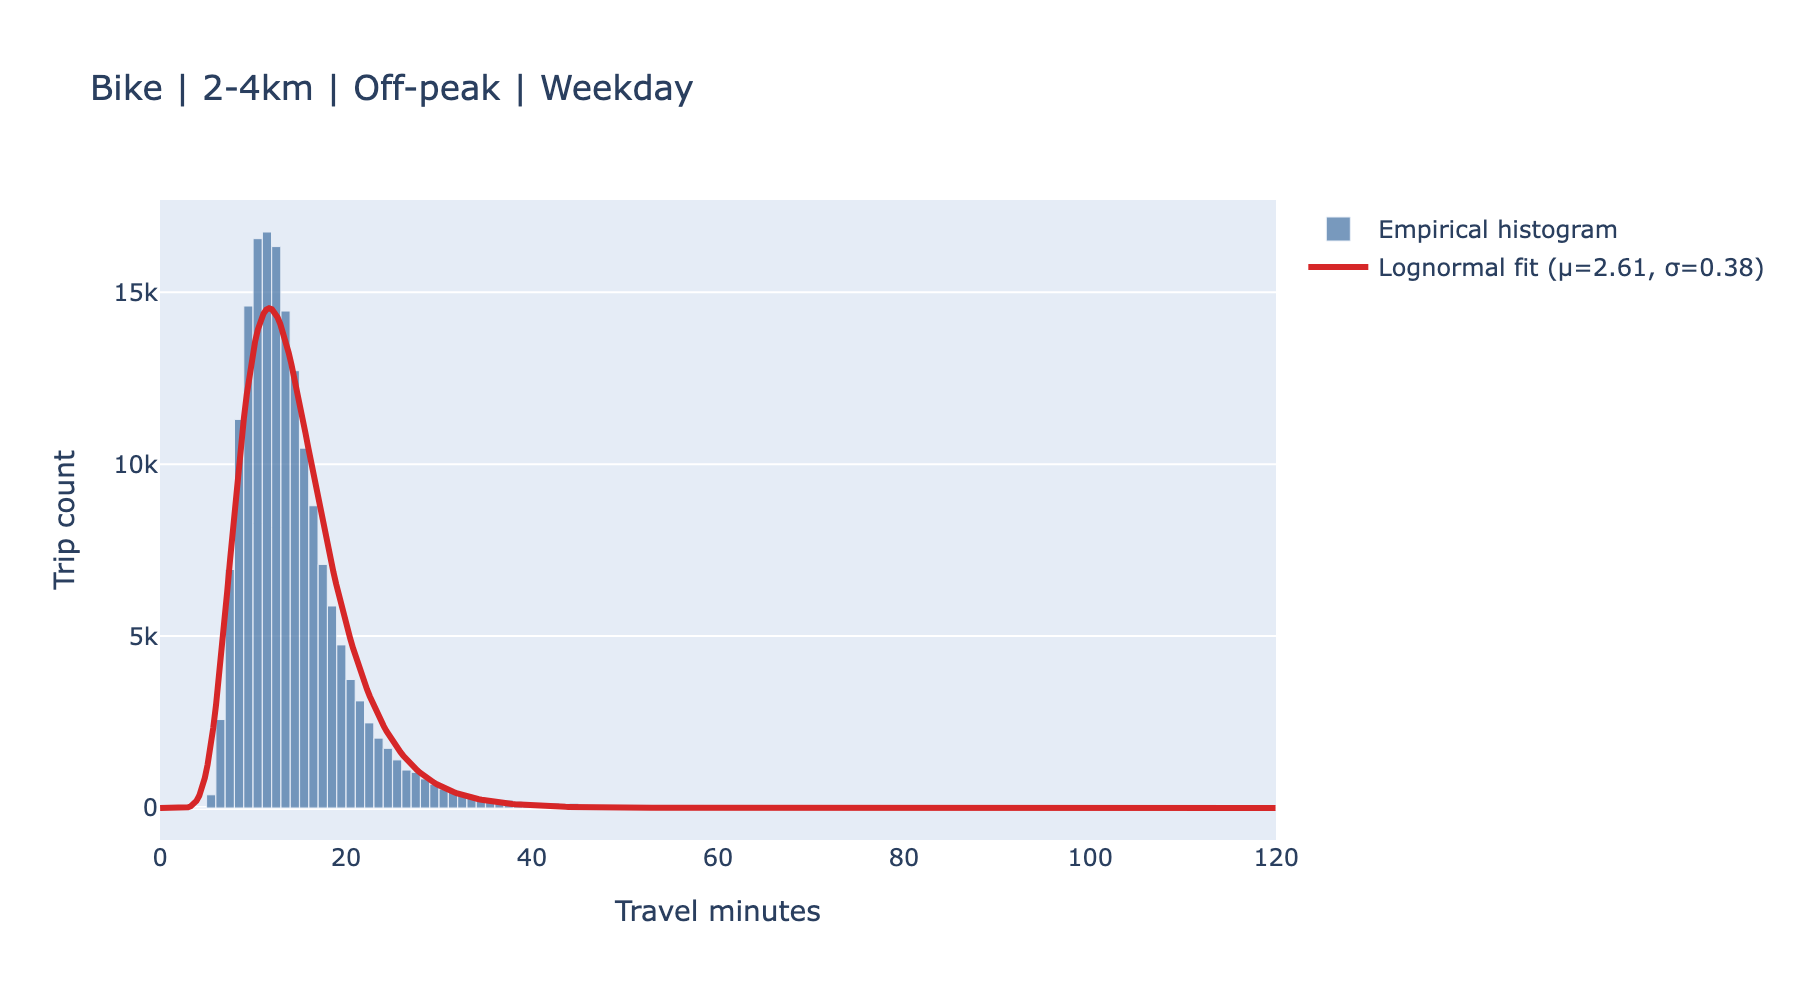

mu_log            2.606332
sigma_log         0.376301
samples      173072.000000
Name: lognormal_params, dtype: float64

In [80]:

def render_static_lognorm_snapshot(
    mode='bike',
    distance_bin_label=None,
    is_rush=False,
    is_weekend=False,
):
    if distance_bin_label is None:
        distance_bin_label = distance_levels[1] if len(distance_levels) > 1 else distance_levels[0]
    fig, stats = render_lognormal_overlay(mode, distance_bin_label, is_rush, is_weekend)
    png = fig.to_image(format='png', width=900, height=500, scale=2)
    display(Markdown(f"**Lognormal overlay snapshot — {mode.title()}, {distance_bin_label}, "
                     f"{'Rush' if is_rush else 'Off-peak'}, {'Weekend' if is_weekend else 'Weekday'}**"))
    display(Image(png))
    if stats:
        display(pd.Series(stats, name='lognormal_params'))

render_static_lognorm_snapshot()


## Continuous lognormal GLM fit

Here we actually fit an accelerated failure-time style model: take `log(travel_min)` as the response and regress it on continuous distance plus rush/weekend indicators. statsmodels' Gaussian GLM handles this directly; exponentiating the fitted log-mean and adding `0.5·σ²` recovers the lognormal expected value, giving us a smooth prediction surface without discrete bins.

In [81]:

def build_lognormal_design(df: pd.DataFrame) -> pd.DataFrame:
    """Design matrix with distance curvature and rush/weekend flags."""
    design = pd.DataFrame(
        {
            'distance_km': df['distance_km'],
            'distance_sq': df['distance_km'] ** 2,
            'is_rush': df['is_rush'].astype(int),
            'is_weekend': df['is_weekend'].astype(int),
        }
    )
    return sm.add_constant(design, has_constant='add')


lognormal_coeffs = {}
lognormal_scales = {}
lognormal_metrics = []
combined_trips['log_glm_pred_minutes'] = np.nan
combined_trips['log_glm_log_mu'] = np.nan
combined_trips['log_glm_residual'] = np.nan

for mode in sorted(combined_trips['mode'].unique()):
    subset = combined_trips.loc[combined_trips['mode'] == mode].copy()
    if subset.empty:
        continue
    design = build_lognormal_design(subset)
    log_minutes = np.log(subset['travel_min'].values)
    model = sm.GLM(log_minutes, design, family=sm.families.Gaussian())
    result = model.fit()
    mu_hat = result.predict(design)
    sigma2 = float(result.scale)
    pred_minutes = np.exp(mu_hat + 0.5 * sigma2)
    residuals = subset['travel_min'].values - pred_minutes

    combined_trips.loc[subset.index, 'log_glm_pred_minutes'] = pred_minutes
    combined_trips.loc[subset.index, 'log_glm_log_mu'] = mu_hat
    combined_trips.loc[subset.index, 'log_glm_residual'] = residuals

    lognormal_coeffs[mode] = {k: float(v) for k, v in result.params.items()}
    lognormal_scales[mode] = sigma2
    lognormal_metrics.append(
        {
            'mode': mode,
            'samples': len(subset),
            'sigma_log': np.sqrt(sigma2),
            'rmse_minutes': float(np.sqrt(np.mean(residuals ** 2))),
            'mae_minutes': float(np.mean(np.abs(residuals))),
            'r2_log_space': float(
                1
                - np.sum((log_minutes - mu_hat) ** 2)
                / np.sum((log_minutes - log_minutes.mean()) ** 2)
            ),
        }
    )

lognormal_summary = pd.DataFrame(lognormal_metrics)
display(lognormal_summary)

coeff_table = pd.DataFrame(lognormal_coeffs).T
coeff_table['sigma_log'] = pd.Series({mode: np.sqrt(scale) for mode, scale in lognormal_scales.items()})
display(coeff_table)


,mode,samples,sigma_log,rmse_minutes,mae_minutes,r2_log_space
0,bike,1841613,0.442065,6.574742,3.435930,0.646435
1,taxi,2559175,0.369738,5.053254,3.366482,0.642637


,const,distance_km,distance_sq,is_rush,is_weekend,sigma_log
bike,1.024884,0.730378,-0.053595,-0.008792,0.012071,0.442065
taxi,1.210881,0.509080,-0.032011,0.055717,-0.092633,0.369738


## Lognormal GLM diagnostics

Use the widget to inspect the lognormal predictions for each mode. We compare the expected minutes (exp(μ+0.5σ²)) against observations and look at residual distributions to confirm the continuous model outperforms coarse bins.

In [82]:

lognormal_diag_output = widgets.Output()
lognormal_mode_widget = widgets.ToggleButtons(options=sorted(lognormal_coeffs.keys()), description='Mode')


def render_lognormal_diag(mode: str):
    subset = combined_trips[combined_trips['mode'] == mode].dropna(subset=['log_glm_pred_minutes']).copy()
    if subset.empty:
        display(Markdown(f'No fitted samples for {mode}.'))
        return
    subset['rush_label'] = subset['is_rush'].map({True: 'Rush', False: 'Off-peak'})
    subset['weekend_label'] = subset['is_weekend'].map({True: 'Weekend', False: 'Weekday'})
    scatter_sample = subset.sample(n=min(len(subset), 6000), random_state=42) if len(subset) > 6000 else subset

    fig_scatter = px.scatter(
        scatter_sample,
        x='log_glm_pred_minutes',
        y='travel_min',
        color='rush_label',
        opacity=0.6,
        title=f"Lognormal GLM predictions — {mode.title()}",
        labels={'log_glm_pred_minutes': 'Predicted minutes', 'travel_min': 'Observed minutes'},
    )
    max_val = max(subset['travel_min'].max(), subset['log_glm_pred_minutes'].max())
    fig_scatter.add_trace(
        go.Scatter(x=[0, max_val], y=[0, max_val], name='Ideal', line=dict(color='black', dash='dash'))
    )

    fig_residual = px.histogram(
        subset,
        x='log_glm_residual',
        color='weekend_label',
        nbins=60,
        opacity=0.7,
        title=f"Residuals (observed - predicted) — {mode.title()}",
        labels={'log_glm_residual': 'Residual minutes', 'weekend_label': 'Weekend flag'},
    )

    coef_df = pd.Series(lognormal_coeffs[mode]).to_frame(name='coefficient')
    coef_df.loc['sigma_log'] = np.sqrt(lognormal_scales[mode])

    display(Markdown(f"**Samples:** {len(subset):,} | σ_log={np.sqrt(lognormal_scales[mode]):.3f}"))
    display(coef_df)
    display(fig_scatter)
    display(fig_residual)


def update_lognormal_diag(*_):
    with lognormal_diag_output:
        lognormal_diag_output.clear_output(wait=True)
        render_lognormal_diag(lognormal_mode_widget.value)


lognormal_mode_widget.observe(update_lognormal_diag, names='value')
display(lognormal_mode_widget)
display(lognormal_diag_output)
update_lognormal_diag()


ToggleButtons(description='Mode', options=('bike', 'taxi'), value='bike')

Output()

## Log-likelihood comparison

To decide between Gamma bins and the continuous lognormal GLM we compute per-trip log-likelihoods under each distribution and aggregate them. Higher (less negative) log-likelihood means the model explains the observed durations better, even after accounting for the number of parameters.

In [83]:

def gamma_logpdf(x, k, theta):
    valid = (x > 0) & np.isfinite(k) & np.isfinite(theta) & (k > 0) & (theta > 0)
    out = np.full_like(x, np.nan, dtype=float)
    out[valid] = ((k[valid] - 1) * np.log(x[valid])
                  - x[valid] / theta[valid]
                  - k[valid] * np.log(theta[valid])
                  - gammaln(k[valid]))
    return out


def lognormal_logpdf(x, mu, sigma):
    valid = (x > 0) & np.isfinite(mu) & np.isfinite(sigma) & (sigma > 0)
    out = np.full_like(x, np.nan, dtype=float)
    diff = np.log(x[valid]) - mu[valid]
    out[valid] = -0.5 * (diff ** 2) / (sigma[valid] ** 2) - np.log(x[valid] * sigma[valid] * np.sqrt(2 * np.pi))
    return out


gamma_lookup = bin_stats[['mode', 'distance_bin', 'is_rush', 'is_weekend', 'gamma_k', 'gamma_theta', 'sample_count']].copy()
gamma_lookup['distance_bin'] = gamma_lookup['distance_bin'].astype(str)

merged = combined_trips.merge(
    gamma_lookup,
    how='left',
    left_on=['mode', 'distance_bin_label', 'is_rush', 'is_weekend'],
    right_on=['mode', 'distance_bin', 'is_rush', 'is_weekend'],
    suffixes=('', '_bin')
)

sigma_map = {mode: np.sqrt(scale) for mode, scale in lognormal_scales.items()}
merged['log_glm_sigma'] = merged['mode'].map(sigma_map)

valid_mask = (
    merged['gamma_k'].notna()
    & merged['gamma_theta'].notna()
    & merged['sample_count'].ge(GAMMA_MIN_SAMPLES)
    & merged['log_glm_log_mu'].notna()
    & merged['log_glm_sigma'].notna()
)

compare = merged.loc[valid_mask].copy()
compare['gamma_loglike'] = gamma_logpdf(compare['travel_min'].values, compare['gamma_k'].values, compare['gamma_theta'].values)
compare['lognormal_loglike'] = lognormal_logpdf(compare['travel_min'].values, compare['log_glm_log_mu'].values, compare['log_glm_sigma'].values)

ll_summary = (
    compare.groupby('mode')[['gamma_loglike', 'lognormal_loglike']]
    .sum()
    .assign(delta=lambda df: df['lognormal_loglike'] - df['gamma_loglike'])
)
display(Markdown('**Aggregate log-likelihood (higher is better):**'))
display(ll_summary)

per_trip = (
    compare.groupby('mode')[['gamma_loglike', 'lognormal_loglike']]
    .mean()
    .rename(columns={'gamma_loglike': 'gamma_mean', 'lognormal_loglike': 'lognormal_mean'})
)
display(Markdown('**Average log-likelihood per trip:**'))
display(per_trip)

overall_delta = compare['lognormal_loglike'].sum() - compare['gamma_loglike'].sum()
print(f"Overall Δ log-likelihood (lognormal - gamma): {overall_delta:,.2f} across {len(compare):,} comparable trips")


**Aggregate log-likelihood (higher is better):**

,gamma_loglike,lognormal_loglike,delta
mode,,,
bike,-5.433862e+06,-4.878057e+06,555804.764604
taxi,-7.243350e+06,-7.024916e+06,218433.704444


**Average log-likelihood per trip:**

,gamma_mean,lognormal_mean
mode,,
bike,-2.950599,-2.648796
taxi,-2.830346,-2.744992


Overall Δ log-likelihood (lognormal - gamma): 774,238.47 across 4,400,788 comparable trips


## Takeaways

* The Gamma overlay closely tracks the empirical histograms except for the handful of cohorts with <50 trips, validating the Component 2 binning and threshold choices.
* Regression fallbacks explain most of the variance (see R² values) while remaining simple enough for the product code path.
* This notebook now pairs with `notebooks/wait_times/combined_dashboard.ipynb`, giving us parity in how we justify both wait-time (Component 1) and travel-time (Component 2) modeling assumptions.